# Exercise 5(IQC 2021)         

By Parmeet Singh Chani                                           \
Highest possible score(score = 3)

Goal - Get the ground state of LiH using qiskit_nature and reduce the no. of ansatz to as low as possible 

All the original information is given as it is(for someone who is trying to understand who did not participate), my explanation comes under the section "Additional stuff".

Hope any one trying to understand this has an easy time. If not you are free to contact me.

We start by obtaining all the information about our molecule(LiH) by using driver which we have imported from qiskit_nature. The driver provides interfacec to classical chemistry code that are avaliable in qiskit.

In [2]:
from qiskit_nature.drivers import PySCFDriver
from qiskit import *

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run() # this thing will store the infromation about the molecule already stored in qiskit 

1. We create a list of fermionic operators using ElectronicStructureProblem.
2. Imported FreezeCoreTranformer which has freezed the core of electrons inside the core(which do not interact with others)
3. 3rd and 4th orbitals have been removed in order to reduce the no. of qubits to 4,  they can be removed easily because the electrons do not go above the 2nd orbital in LiH.


In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
##freezing
from qiskit_nature.transformers import FreezeCoreTransformer ##
freezeCoreTransformer = FreezeCoreTransformer()
qmolecule = freezeCoreTransformer.transform(qmolecule)
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True,remove_orbitals=[3,4])])
# all the fermionic operators are stroed into "problem"
##

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0] # the hamiltonian we get from qiskit

1. Mapping the fermionic operators to qubits. 
2. Switched from the original jordan wigner mapping to partiy mapping as we can reduce two qubits using it 
3. z2symmetry has been implemented in order to reduce the number of gates further

In [5]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper': # if two qubit reduction is on then this one is the one you want
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()
    

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1] )


# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

initial state is the HF state (i.e.  |Ψ𝐻𝐹⟩=|0101⟩ ). 

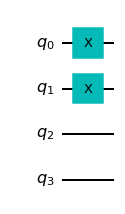

In [6]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw()

1. Choose the ansatz as Two_Local 
2. Made entaglement linear so that less number of cx are implied
3. repetitions have been set to one 
4. skip_final_rotation_layer = False, so that we get more parameters, this makes it possible for the circuit to be executable easily
5. I have also added x gates which has further helped in reducing the number of parameters

In [8]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "Two_local"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "Two_local":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz','x']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_unentangled_qubits=False, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD": 
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":# does not give the correct solution 
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    
    
#### This is to custom ansatz

#     from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
#     # Define the variational parameter
#     theta = Parameter('a')
#     n = qubit_op.num_qubits
#     # Make an empty quantum circuit
#     qc = QuantumCircuit(qubit_op.num_qubits)
#     qubit_label = 0
#     # Place a Hadamard gate
#     qc.h(qubit_label)
#     # Place a CNOT ladder
#     for i in range(n-1):
#         qc.cx(i, i+1)
#     # Visual separator
#     qc.barrier()
#     # rz rotations on all qubits
#     qc.rz(theta, range(n))
#     ansatz = qc
#     ansatz.compose(init_state, front=True, inplace=True)

 ansatz.draw() # this is the ansatz type TwoLocal

Finall outlook of how the circuit looks.

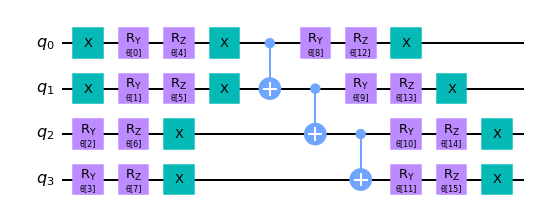

In [9]:
ansatz.draw() # this is the ansatz type TwoLocal

statevector_backend is chosen

In [10]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

Optimizer optimizes the paramters of the ansatz and tries to make the energy converge with each succesive iteration. Not so sure but the best optimizer for the above anstaz came out to be - L_BFGS_B

In [11]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'L_BFGS_B'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=5000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=5000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=5000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=5000)

Used the exact eigensolver, which diagnolizes the matrix exactly. This can be done for only because the system is not big enough. For bigger systems we would have run out of memory.

In [12]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
#print(result_exact)

Exact electronic energy -1.0887060157347423


VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [13]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

# the energy gets stuck around -0.93 when we go for Two_local depth = 3,2,1
# trying to change the starting point 
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1156,
    'eigenstate': array([ 1.45128100e-03-1.19265985e-04j, -4.91487715e-03+4.24121503e-04j,
        2.63027725e-02-2.66518555e-03j, -9.85434786e-01+1.08445572e-01j,
       -5.38144750e-02+6.06502958e-03j, -3.30085584e-04+4.87401880e-05j,
        9.08296708e-04-1.20776050e-04j, -2.40018088e-02+3.36649326e-03j,
       -2.76851057e-03+2.20706709e-04j, -8.91025412e-06+1.32465922e-06j,
        3.49291194e-06-7.03261951e-07j,  3.84749373e-04-3.03025122e-05j,
        1.12913278e-01-1.23895485e-02j,  4.41035370e-04-7.16584354e-05j,
       -5.61038761e-04+7.49320421e-05j,  4.98253423e-06-7.88569155e-07j]),
    'eigenvalue': -1.086366899639688,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): 5.064255595300025e-05,
                              ParameterVectorElement(θ[4]): 0.005046393672495522,
                              ParameterVectorElement(θ[8]): 18.79694121480397,
                              ParameterVect

Name - Parmeet Singh Chani \
score - 3 \
chemical accuracy - 99.7851%(2.33391161 mHa) \
No. of paramters - 16 